In [65]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pickle
from scipy.interpolate import griddata
import csv
from PIL import Image
from IPython.display import display, Image as IPImage
import os

%run -i storm_coords.py
%run -i wave_stats.py

In [2]:
# Load the contour file
contour_file = 'contour30sp.csv'
df = pd.read_csv( contour_file )
contour30sp = np.column_stack( (df['contour30s_lon'], df['contour30s_lat']) )
normals30sp = np.column_stack( (df['normals30_x'], df['normals30_y']) )
xy30sp = np.column_stack( (df['contour30s_x'], df['contour30s_y']) )
df

,contour30s_lon,contour30s_lat,contour30s_x,contour30s_y,normals30_x,normals30_y
0,-87.996666,29.957025,-175949.630035,3.334697e+06,-0.016403,0.999865
1,-87.976110,29.958401,-173949.422369,3.334729e+06,-0.015628,0.999878
2,-87.955553,29.959775,-171949.216696,3.334760e+06,-0.016449,0.999865
3,-87.934997,29.961174,-169949.063175,3.334794e+06,-0.018703,0.999825
4,-87.914445,29.962622,-167949.019645,3.334835e+06,-0.022237,0.999753
...,...,...,...,...,...,...
420,-82.449104,25.594547,354473.054765,2.831579e+06,0.984630,0.174656
421,-82.445504,25.576785,354813.180253,2.829608e+06,0.986246,0.165286
422,-82.442094,25.558991,355134.340815,2.827633e+06,0.987806,0.155690
423,-82.438878,25.541168,355436.071103,2.825656e+06,0.989306,0.145856


In [3]:
contour_points = contour30sp
normals = normals30sp
contour_xy = xy30sp
print("Number of contour points: ",len(contour_points))
# Compute distance along contour
dxyc = np.diff(contour_xy, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('Contour spacing (min, max, avg): {:.2f}, {:.2f}, {:.2f} km'.format(np.min(delc)/1000., np.max(delc)/1000., np.mean(delc)/1000. ))
contour_dist = np.hstack((0, np.cumsum( delc )))/1000.
print('Contour length: ',contour_dist[-1], 'km' )

Number of contour points:  425
Contour spacing (min, max, avg): 2.00, 2.00, 2.00 km
Contour length:  848.187204082548 km


In [4]:
# Read the wave model history file...this has higher density fields for depth and bulk model results
his_url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'
ds = xr.open_dataset(his_url)

model_lat = ds['lat_rho'].values  # Shape (512, 833)
model_lon = ds['lon_rho'].values  # Shape (512, 833)
model_h = ds['h'].values        # Shape (512, 833)
ocean_time = ds['ocean_time'].values
ntimes = len( ocean_time )
print(f'Length of ocean_time {ntimes}')
ds

Length of ocean_time 121


<xarray.Dataset> Size: 32GB
Dimensions:          (tracer: 2, s_rho: 16, s_w: 17, eta_rho: 512, xi_rho: 833,
                      eta_u: 512, xi_u: 832, eta_v: 511, xi_v: 833,
                      eta_psi: 511, xi_psi: 832, ocean_time: 121)
Coordinates:
  * s_rho            (s_rho) float64 128B -0.9688 -0.9062 ... -0.09375 -0.03125
  * s_w              (s_w) float64 136B -1.0 -0.9375 -0.875 ... -0.0625 0.0
    lon_rho          (eta_rho, xi_rho) float64 3MB -87.02 -87.01 ... -78.52
    lat_rho          (eta_rho, xi_rho) float64 3MB 20.85 20.86 ... 35.89 35.9
    lon_u            (eta_u, xi_u) float64 3MB ...
    lat_u            (eta_u, xi_u) float64 3MB ...
    lon_v            (eta_v, xi_v) float64 3MB ...
    lat_v            (eta_v, xi_v) float64 3MB ...
    lon_psi          (eta_psi, xi_psi) float64 3MB ...
    lat_psi          (eta_psi, xi_psi) float64 3MB ...
  * ocean_time       (ocean_time) datetime64[ns] 968B 2024-09-24 ... 2024-09-29
Dimensions without coordinates: tracer, eta_rho, xi_rho, eta_u, xi_u, eta_v,
                                xi_v, eta_psi, xi_psi
Data variables: (12/113)
    ntimes           int32 4B ...
    ndtfast          int32 4B ...
    dt               float64 8B ...
    dtfast           float64 8B ...
    dstart           datetime64[ns] 8B ...
    nHIS             int32 4B ...
    ...               ...
    Lwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Lwavep           (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_top        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_bot        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Uwave_rms        (ocean_time, eta_rho, xi_rho) float32 206MB ...
Attributes: (12/33)
    file:                            Output/coawst_gomsab_his.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           COAWST ROMS SWAN
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 4.1, Wednesday - Octo...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     COAWST, ANA_BSFLUX, ANA_BTFLUX, ANA_FSOB...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               16
    EXTRA_DIMENSION.boundary:        4

In [ ]:
model_shape = np.shape( model_lon )
print('model shape: ', model_shape )
npoints = len( contour_points )

# Set up some arrays for output
h_avg = np.nan*np.ones( npoints )
h_min = h_avg.copy()
h_max = h_avg.copy()
Hwave_avg = np.nan*np.ones( (npoints, ntimes) )
Hwave_min = Hwave_avg.copy()
Hwave_max = Hwave_avg.copy()
Pwave_avg = Hwave_avg.copy()
Pwave_min = Hwave_avg.copy()
Pwave_max = Hwave_avg.copy()
Dwave_avg = Hwave_avg.copy()
Dwave_min = Hwave_avg.copy()
Dwave_max = Hwave_avg.copy()

print(np.shape(Hwave_avg))

# Iterate over each contour point
for i, contour_point in enumerate( contour_points):
    clon, clat = contour_point
    print(f'Contour point: {clon}, {clat}')

    # Calculate distances from the contour point to each model grid point
    distances = haversine(clon, clat, np.ravel(model_lon), np.ravel(model_lat))  # Flatten the model grid
    #print(f'Distances: {distances[:10]}')  # Print the first 10 distances for checking

    # Get the indices of the four closest points
    near_dists_flat_idx = np.argsort(distances)[:4]  # Sort distances and get the 4 smallest indices
    #print(f'Nearest 4 indices: {near_dists_flat_idx}')

    # Convert the flat indices into 2D indices
    near_idx = np.unravel_index(near_dists_flat_idx, model_shape)  # Get the 2D indices
    #print(f'2D indices of nearest points: {near_idx}')
    
    # Get the corresponding model values at those indices
    lat_near = model_lat[near_idx]
    lon_near = model_lon[near_idx]
    h_near = model_h[near_idx]

    h_avg[i] = bilinear_interpolation(distances[near_dists_flat_idx], h_near)
    h_min[i] = np.min( h_near )
    h_max[i] = np.max( h_near )
    
    # print(f'Nearest Latitudes: {lat_near}')
    # print(f'Nearest Longitudes: {lon_near}')
    # print(f'Nearest Heights: {h_near}')
    # print(f'Interpolated h: {h_avg[i]}')
    # print(" ")

    for j, t in enumerate( ocean_time ):
        Hwave_near = np.array([ds['Hwave'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        Dwave_near = np.array([ds['Dwave'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        Pwave_near = np.array([ds['Pwave_top'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        
        # Apply bilinear interpolation for Hwave, Dwave, and Pwave_top
        Hwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Hwave_near)
        Dwave_avg[i, j] = direction_bilinear_interpolation(distances[near_dists_flat_idx], Dwave_near)
        Pwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Pwave_near)
        
        # Calculate the min and max values of the nearest points for Hwave, Dwave, and Pwave_top
        Hwave_min[i, j] = np.min(Hwave_near)
        Hwave_max[i, j] = np.max(Hwave_near)

        Dwave_min[i, j] = np.min(Dwave_near)
        Dwave_max[i, j] = np.max(Dwave_near)

        Pwave_min[i, j] = np.min(Pwave_near)
        Pwave_max[i, j] = np.max(Pwave_near)



In [ ]:
# TODO...need to save that output, because it takes a long time to calculate

# npoints, ntimes : ints
# times           : array-like of datetimes (np.datetime64, pandas, or strings)
# lats, lons      : shape (npoints,)
# northings, eastings : shape (npoints,)

# Your data arrays (examples as in your message)
# 1D per-point stats
# h_avg, h_min, h_max : shape (npoints,)

# 2D time series per point
# Hwave_avg, Hwave_min, Hwave_max : shape (npoints, ntimes)
# Pwave_avg, Pwave_min, Pwave_max : shape (npoints, ntimes)
# Dwave_avg, Dwave_min, Dwave_max : shape (npoints, ntimes)

# rename for convenience
npoints = len( contour_points )
eastings = contour_xy[:,0]
northings = contour_xy[:,1]
lats = contour_points[:,0]
lons = contour_points[:,1]
nc_title = "Alongshore wave statistics at 30-m contour points"
nc_history = "processed by extract_eflux_on_contour.ipynb"
wave_output = "his_url"

# --- build dataset ---
# Normalize coords
point = np.arange(npoints)  # integer index for alongshore points
time = pd.to_datetime(ocean_time)  # robust conversion from many input types

coords = {
    "point": point,
    "time":  time,
    "lat":   ("point", np.asarray(lats)),
    "lon":   ("point", np.asarray(lons)),
    "northing": ("point", np.asarray(northings)),
    "easting":  ("point", np.asarray(eastings)),
}

data_vars = {
    # per-point (no time)
    "h_avg": (("point",), np.asarray(h_avg), {"long_name": "mean water depth (or elevation) at point", "units": "m"}),
    "h_min": (("point",), np.asarray(h_min), {"long_name": "min water depth (or elevation) at point", "units": "m"}),
    "h_max": (("point",), np.asarray(h_max), {"long_name": "max water depth (or elevation) at point", "units": "m"}),

    # wave height (Hs)
    "Hwave_avg": (("point", "time"), np.asarray(Hwave_avg), {"long_name": "significant wave height (mean)", "units": "m"}),
    "Hwave_min": (("point", "time"), np.asarray(Hwave_min), {"long_name": "significant wave height (min)", "units": "m"}),
    "Hwave_max": (("point", "time"), np.asarray(Hwave_max), {"long_name": "significant wave height (max)", "units": "m"}),

    # wave energy/power flux (along-crest)
    "Pwave_avg": (("point", "time"), np.asarray(Pwave_avg), {"long_name": "wave energy flux (mean)", "units": "W m-1"}),
    "Pwave_min": (("point", "time"), np.asarray(Pwave_min), {"long_name": "wave energy flux (min)", "units": "W m-1"}),
    "Pwave_max": (("point", "time"), np.asarray(Pwave_max), {"long_name": "wave energy flux (max)", "units": "W m-1"}),

    # wave direction (geographic, coming from)
    "Dwave_avg": (("point", "time"), np.asarray(Dwave_avg), {"long_name": "wave direction (mean, geographic, degrees)", "units": "degrees"}),
    "Dwave_min": (("point", "time"), np.asarray(Dwave_min), {"long_name": "wave direction (min, geographic, degrees)", "units": "degrees"}),
    "Dwave_max": (("point", "time"), np.asarray(Dwave_max), {"long_name": "wave direction (max, geographic, degrees)", "units": "degrees"}),
}

ds = xr.Dataset(data_vars=data_vars, coords=coords)

# Global metadata (edit as appropriate)
ds.attrs.update({
    "title": nc_title,
    "Conventions": "CF-1.8",
    "institution": "USGS",
    "history": nc_history,
    "source": wave_output,
})

# Optional: chunk before writing (useful for large arrays)
# ds = ds.chunk({"point": min(npoints, 512), "time": min(ntimes, 512)})

# Compression / dtype encoding
float_vars = [
    "h_avg","h_min","h_max",
    "Hwave_avg","Hwave_min","Hwave_max",
    "Pwave_avg","Pwave_min","Pwave_max",
    "Dwave_avg","Dwave_min","Dwave_max",
]
encoding = {v: {"zlib": True, "complevel": 4, "dtype": "float32", "_FillValue": np.float32(np.nan)} for v in float_vars}
# Time encoding (optional, CF-friendly numeric time)
encoding["time"] = {"units": "seconds since 1970-01-01 00:00:00", "calendar": "standard"}

# Save to NetCDF
out_path = "alongshore_wave_stats.nc"
ds.to_netcdf(out_path, format="NETCDF4", encoding=encoding)
print(f"Wrote {out_path}")


In [8]:
# Read everything back in again 
import xarray as xr
import numpy as np

# Read the dataset
ds = xr.open_dataset("alongshore_wave_stats.nc")

# --- coords ---
times     = ds["time"].values             # np.datetime64 array
lats      = ds["lat"].values
lons      = ds["lon"].values
northings = ds["northing"].values
eastings  = ds["easting"].values

# --- 1D per-point arrays ---
h_avg = ds["h_avg"].values
h_min = ds["h_min"].values
h_max = ds["h_max"].values

# --- 2D (point × time) arrays ---
Hwave_avg = ds["Hwave_avg"].values
Hwave_min = ds["Hwave_min"].values
Hwave_max = ds["Hwave_max"].values

Pwave_avg = ds["Pwave_avg"].values
Pwave_min = ds["Pwave_min"].values
Pwave_max = ds["Pwave_max"].values

Dwave_avg = ds["Dwave_avg"].values
Dwave_min = ds["Dwave_min"].values
Dwave_max = ds["Dwave_max"].values

# optional: also recover npoints, ntimes
npoints, ntimes = Hwave_avg.shape

ds.close()


(425, 121)


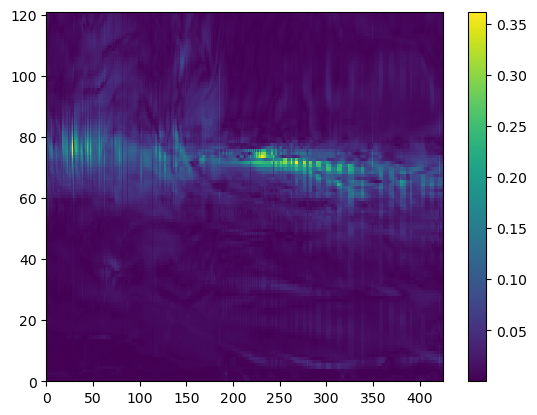

In [12]:
print(np.shape(Hwave_avg))
_ = plt.pcolormesh( (Hwave_max[:,:]-Hwave_min[:,]).T)
plt.colorbar()

In [13]:
# Estimate wave energy flux from Hs, Tp, and Dav
# Flux = energy * group celerity = E * cg
Eflux = np.nan*np.ones( (npoints, ntimes) )
EfluxS = Eflux.copy()
_, Sdir = pcoord( normals[:,0], normals[:,1] )

# N.B. - Dwave is direction waves are FROM. Need to rotate 180 for plotting...thus the modulus operator.
for i in range( npoints ):
    for j in range( ntimes ):
        Eflux[i, j] = calc_Eflux( Hwave_avg[i, j], Pwave_avg[i, j], h_avg[i] )
        EfluxS[i, j] = calc_EfluxS( Eflux[i,j], (Dwave_avg[i,j] + 180.) % 360., normals[i, 0], normals[i, 1] )


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_17656\429661225.py:41: RuntimeWarning: overflow encountered in sinh
  n = 0.5 * ( 1. + 2*kh/np.sinh( 2 * kh ) )


Text(0.5, 0, 'Alongshore Distance (km)')

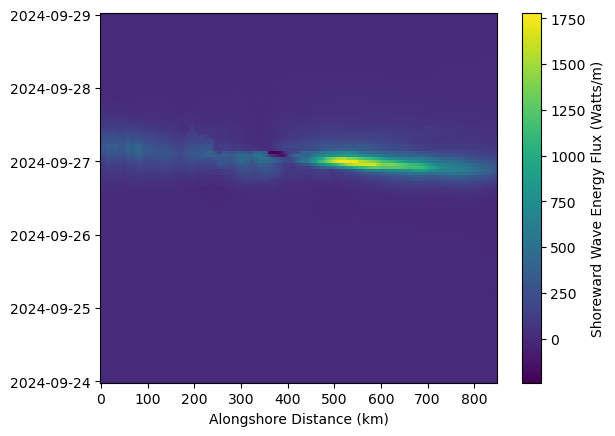

In [14]:
_ = plt.pcolormesh( contour_dist, ocean_time, EfluxS.T)
plt.colorbar(label='Shoreward Wave Energy Flux (Watts/m)')
plt.xlabel('Alongshore Distance (km)')

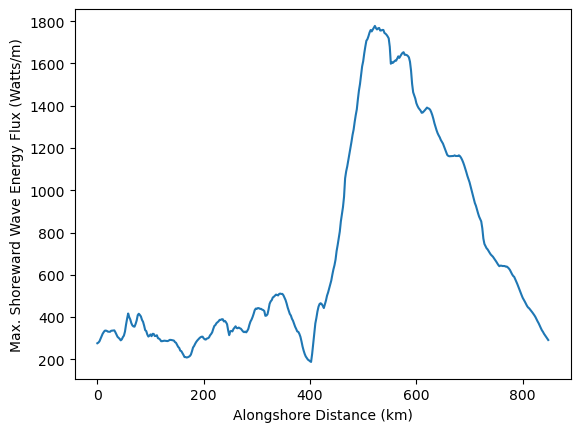

In [15]:
# Eliminate offshore fluxes
EfluxS[ EfluxS < 0. ] = 0.
mxEfluxS = np.max(EfluxS, 1)
np.shape(mxEfluxS)
plt.plot(contour_dist, mxEfluxS )
plt.xlabel('Alongshore Distance (km)')
plt.ylabel('Max. Shoreward Wave Energy Flux (Watts/m)')
plt.show()

Total flux integrated over time = 1.633e+13 J


Text(0.5, 0, 'Along-Contour Distance (km)')

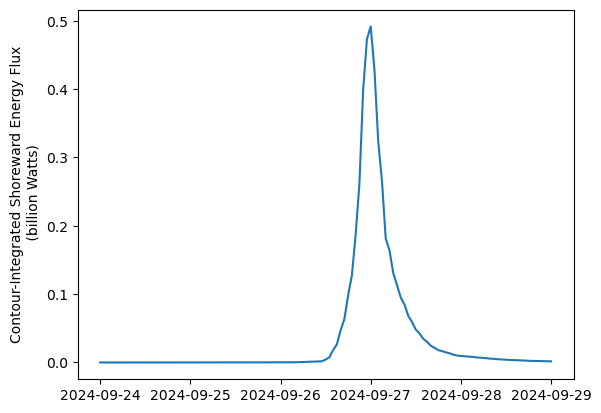

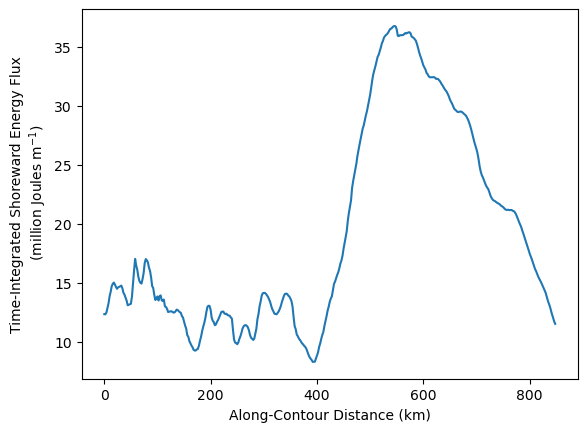

In [44]:
# integrate the total wave energy flux across the contour
from scipy.integrate import trapezoid
x_m = np.asarray(contour_dist) * 1000.0  # km -> m
EfluxSC = trapezoid(EfluxS, x=x_m, axis=0)     # shape: (ntimes,), units = Watts = Joules/s = kg m^2 s^-3


# now integrate over time for the total shoreward flux
# Convert times to elapsed seconds relative to start
t_sec = (time - time[0]).total_seconds().to_numpy()   # shape (ntimes,)

# also, integrate the shoreward flux over time at each contour point
EfluxST = trapezoid(EfluxS, x=t_sec, axis=1) # Joules meter

# Integrate in time (Watts × seconds → Joules)
EfluxSCT = trapezoid(EfluxSC, x=t_sec)

print(f"Total flux integrated over time = {EfluxSCT:.3e} J")

plt.figure()
plt.plot(time, EfluxSC/1.e9)
plt.ylabel( 'Contour-Integrated Shoreward Energy Flux\n (billion Watts)' )

plt.figure()
plt.plot(contour_dist, EfluxST/1e6)
plt.ylabel( 'Time-Integrated Shoreward Energy Flux\n (million Joules m$^{-1}$)' )
plt.xlabel( 'Along-Contour Distance (km)')

#### According to ChatGPT (better check this)
1.633 × 10¹³ J (Joules) is equivalent to:

4.54 × 10⁶ kilowatt-hours (kWh)
since 1 kWh = 3.6 × 10⁶ J.
That’s the same as the annual electricity use of ~420 U.S. homes (average ~10,700 kWh/house/year).

3.9 kilotons of TNT
since 1 kiloton TNT ≈ 4.184 × 10¹² J.
That’s about ¼ the yield of the Hiroshima bomb (~15 kt).

~13 hours of the Hoover Dam at full power
Hoover Dam generates ~2 GW (2 × 10⁹ W).
Energy over 13 hours = 2 × 10⁹ W × (13 × 3600 s) ≈ 9.4 × 10¹³ J.

Name / scale

There’s no “named” SI unit beyond Joules, but at that scale you can express it in terajoules (TJ):

1.633×10^13 J = 16.3 TJ

So you could say: “The total shoreward wave energy flux during this record was about 16 terajoules.”

354.1123499181683


(0.0, 360.0)

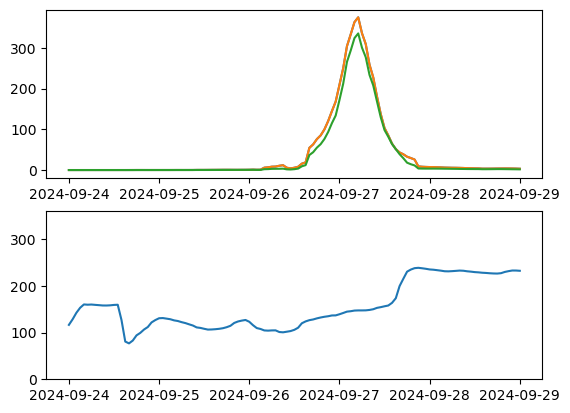

In [21]:
cpt = 14

print(Sdir[cpt])
fig, axs = plt.subplots( 2, 1 )
axs[0].plot( time, Eflux[cpt,:] )
axs[0].plot( time, Eflux[cpt,:] )
axs[0].plot( time, EfluxS[cpt,:] )
axs[1].plot( time, Dwave_avg[cpt,:])
axs[1].set_ylim( 0, 360 )

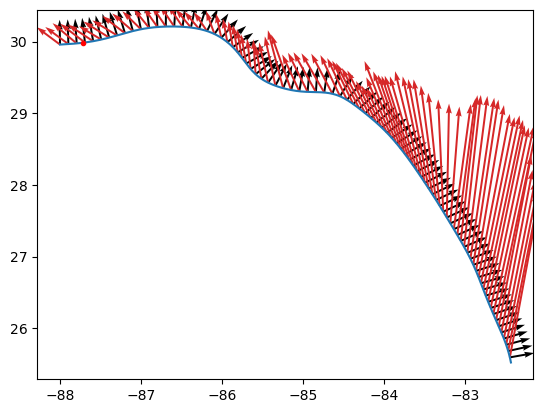

In [48]:
plt.plot( contour_points[:,0], contour_points[:,1])
plt.plot( contour_points[14,0], contour_points[14, 1], '.r')
skip = int(5)
fscale = 1./100.
itime = 65
wx, wy = xycoord(np.ones_like(Dwave_avg[:,itime]), Dwave_avg[:,itime] )
fx, fy = xycoord( Eflux[:,itime], Dwave_avg[:,itime] )
plt.quiver(
    contour_points[::skip, 0], contour_points[::skip, 1], normals[::skip, 0], normals[::skip, 1],
    scale = 20, color = 'black', width = .004)

# plt.quiver(
#     contour_points[::skip, 0], contour_points[::skip, 1], wx[:skip], wy[:skip],
#     scale=10, color = 'tab:blue', width = .004)

# N.B. - Dwave is direction waves are FROM. Minus sign on vectors required to change to propagation direction
plt.quiver(
    contour_points[::skip, 0], contour_points[::skip, 1], -fx[::skip], -fy[::skip],
    scale=1000, color ='tab:red', width = .004)

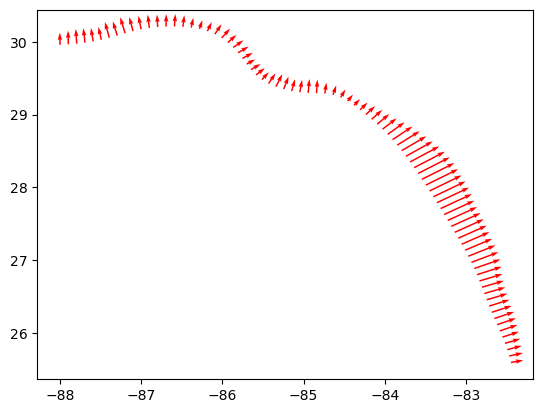

In [64]:
# Plot time-integrated shoreward flux as vectors
_, shoredir = pcoord( normals[:,0], normals[:,1] )
EfSx, EfSy = xycoord( EfluxST, shoredir )
skip = int(5)
plt.quiver(
    contour_points[::skip, 0], contour_points[::skip, 1], EfSx[::skip], EfSy[::skip],
    scale = 5e8, color = 'red', width = .003)

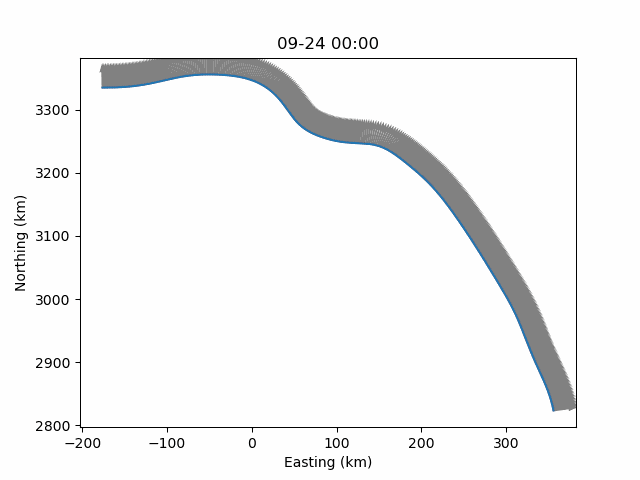

In [15]:
# Animate the fluxes
x = contour_xy[:, 0]/1000  # x coordinates of contour points (shape: [40,])
y = contour_xy[:, 1]/1000  # y coordinates of contour points (shape: [40,])

# Temporary folder for images
temp_dir = "temp_images"
import os
os.makedirs(temp_dir, exist_ok=True)

# Loop to generate and save each plot as an image
for frame in range(ntimes):
    fig, ax = plt.subplots()

    plt.plot( x, y)

    # Generate the data for this frame
    fx, fy = xycoord(Eflux[:, frame], Dwave_avg[:, frame])

    plt.quiver(x[::skip], y[::skip], normals[::skip, 0], normals[::skip, 1],
    scale = 20, color = 'gray', width = .004)

    # Create the quiver plot
    # N.B. - Dwave is direction waves are FROM. Minus sign on vectors required to change to propagation direction
    ax.quiver(x[::skip], y[::skip], -fx[:skip], -fy[:skip],
              scale=1000, color='tab:red', width=0.004)

    # Set axis labels and title (optional)
    ax.set_title(ocean_time[frame].astype(str)[5:10] + " " + ocean_time[frame].astype(str)[11:16] )
    ax.set_xlabel('Easting (km)')
    ax.set_ylabel('Northing (km)')

    # Save the frame as an image
    img_path = os.path.join(temp_dir, f"frame_{frame}.png")
    plt.savefig(img_path)
    plt.close(fig)

# Create a GIF from the saved images using Pillow
image_files = [os.path.join(temp_dir, f"frame_{i}.png") for i in range(ntimes)]
images = [Image.open(img) for img in image_files]

# Save as a GIF
gif_path = "animation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=5)

# Display the GIF in JupyterLab
display(IPImage(gif_path))

# Optionally, delete the temporary image files
import shutil
shutil.rmtree(temp_dir)


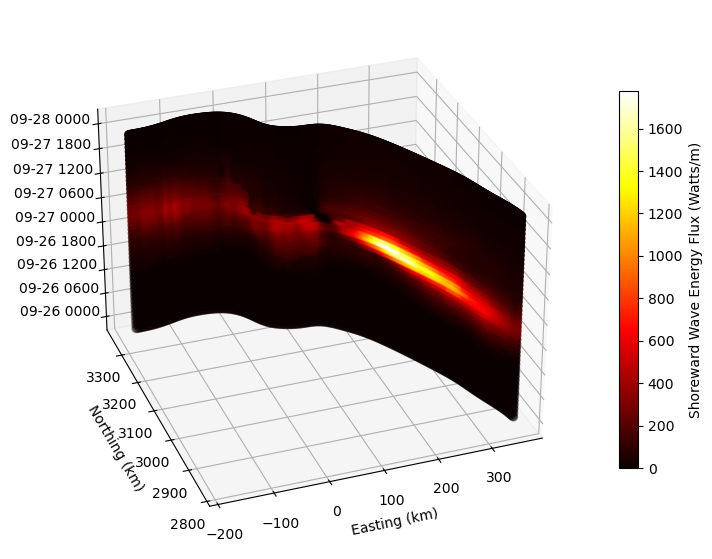

In [16]:
# rename for convenience
x = contour_xy[:, 0]/1000  # x coordinates of contour points (shape: [40,])
y = contour_xy[:, 1]/1000  # y coordinates of contour points (shape: [40,])
wave_energy_flux = EfluxS[:,48:97]  # Shape: [40, 121] (40 contour points, 121 time steps)
# subset of the whole time
otime = np.array(ocean_time[48:97])  # Assuming ocean_time is a datetime64 array

#TODO...use a subset of the points for the vector plot
# Extract the number of contour points and time steps
ncontour_points, ntime_steps = wave_energy_flux.shape

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Set up a color map (you can choose another one if preferred)
cmap = cm.hot
norm = plt.Normalize(vmin=np.min(wave_energy_flux), vmax=np.max(wave_energy_flux))

# Plot vertical strips for each contour point (x, y location)
for i in range(ncontour_points):
    # Extract the time series for this contour point (column in wave_energy_flux)
    time_series = wave_energy_flux[i, :]
    
    # Create the x and y coordinates for the strip (constant for each contour point)
    x_vals = np.full_like(time_series, x[i])  # X coordinate is constant for each point
    y_vals = np.full_like(time_series, y[i])  # Y coordinate is constant for each point

    # Create the z values (time), representing the vertical extent of each strip
    z_vals = np.linspace(0, time_steps - 1, time_steps)

    # Use the wave energy flux as the color of each vertical strip
    sc = ax.scatter(x_vals, y_vals, z_vals, c=time_series, cmap=cmap, norm=norm, s=36)

# Labels and title
ax.set_xlabel('Easting (km)')
ax.set_ylabel('Northing (km)')
#ax.set_zlabel('Time')


# Set the view perspective to look from SW (azimuth: 45, elevation: 30)
ax.view_init(elev=30, azim=250)

# Add a color bar
cbar = plt.colorbar(sc, ax=ax, shrink = 0.7)
cbar.set_label('Shoreward Wave Energy Flux (Watts/m)')

# Format the z-axis to show the actual dates (ocean_time)
labels = []
for i in np.arange(0, len(otime), 6):
    labels.append( str(otime[int(i)])[5:10] +' '+ str(otime[int(i)])[11:13] + '00' )


labels
ax.set_zticks(np.arange(0, len(otime), 6))  # Adjust number of ticks if needed
ax.set_zticklabels(labels)


# Move the z-axis labels farther from the axis by adjusting padding
ax.zaxis.set_tick_params(pad=15)  # Increase this value to move labels farther away

# Show the plot
plt.show()
